<font color='blue'> Please write the name of ALL the member(s) of your team in this cell! </font>

In [67]:
##############################################################################
#OPTIMIZATION & AI - LAB 01
##############################################################################

In [68]:
# System imports
import matplotlib.pyplot as plt
import numpy as np
import datetime
from time import process_time

#Extra library imports
from PIL import Image
from scipy import optimize
import scipy.ndimage as ndi

In [69]:
# User inputs
impath1 = 'butterfly.jpg'

Symmetry is a property observed in various fields such as biology, chemistry, or even nature! For example if you look at the human body from the outside, it is pretty much symmetric with respect to the sagittal plane, which delimitates right and left parts. We will now study this kind of symmetry, called bilateral or mirroring. More especially, we will see that the detection of the bilateral symmetry line can be formulated as an optimization problem in 2D images.

# I. Symmetry analysis of the butterfly

## a) A very short tutorial on image processing

Before detecting the line of symmetry of a butterfly image, we have to understand the concept of image. We first load this image, and convert it into an array.

In [70]:
# Load the input image
im1_arr = np.array(Image.open(impath1))
sx1, sy1, nb_channels = im1_arr.shape
print('Input image of dimension {0}x{1}x{2}'.format(sx1, sy1, nb_channels))
print('Input image of type {0}'.format(type(im1_arr[0, 0, 0])))
print('Minimal intensity value: {0}'.format(np.min(im1_arr.flatten())))
print('Maximal intensity value: {0}'.format(np.max(im1_arr.flatten())))

Input image of dimension 1000x1000x3
Input image of type <class 'numpy.uint8'>
Minimal intensity value: 0
Maximal intensity value: 255


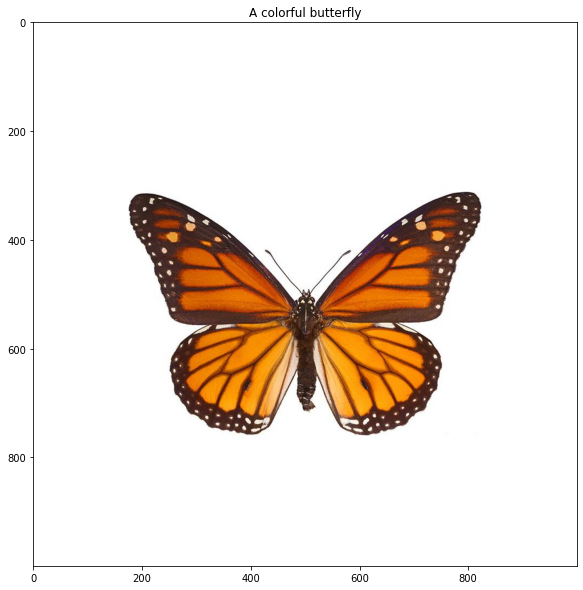

In [71]:
# Display the loaded image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(im1_arr)
plt.title('A colorful butterfly')
plt.show()

We loaded an image of size 1000 x 1000 x 3 pixels: the displayed image is a RGB image, namely a superimposing of the Red, Green and Blue channels (in this order). For each point of the image, called a pixel, each channel contains information about its amount of red, green and blue. 
We can visualize it on each distinct channel.

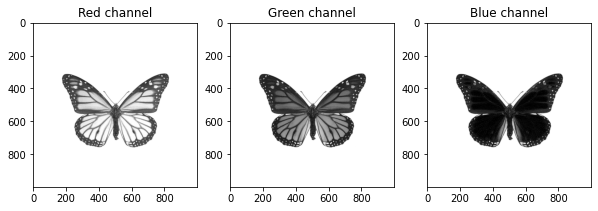

In [72]:
# Display the 3 channels
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
for channel_id, channel_color in enumerate(['Red', 'Green', 'Blue']):
    ax[channel_id].imshow(im1_arr[:, :, channel_id],
                          cmap='gray')
    ax[channel_id].set_title('{0} channel'.format(channel_color))

Each displayed image is an array of dimension 1000x1000 pixels.
Our butterfly is mostly made of shades of red: the image on the red channel is very bright (corresponding to high intensity values), while the ones on the green and blue channels are very dark (corresponding to low intensity values).

To go further, we now want to detect the contours of the butterfly. This task, called segmentation, is very easy here, because of the high difference in intensity values between the foreground and the background!

For simplicity, we will now convert our RGB image into a grey level image. The simplest way for doing that is to average the intensity values over the channels.

In [73]:
# Convert the RGB image into grey levels
glim1_arr = np.mean(im1_arr, axis=-1)
print('Image dimension after transformation : {0}'.format(glim1_arr.shape))

Image dimension after transformation : (1000, 1000)


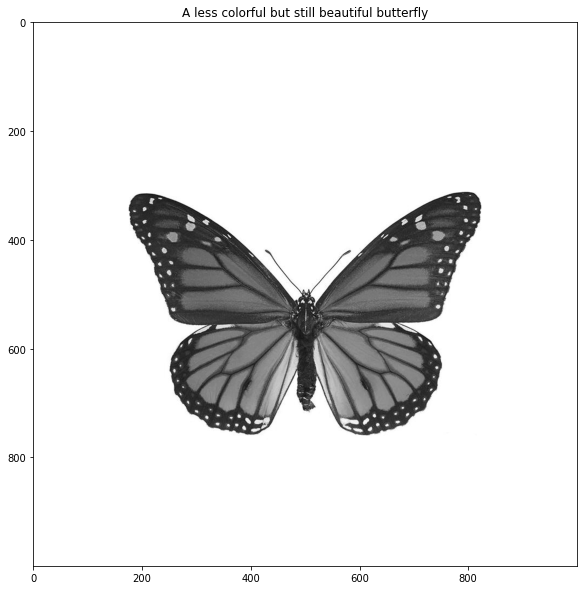

In [74]:
# Display the grey level image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(glim1_arr, cmap='gray')
plt.title('A less colorful but still beautiful butterfly')
plt.show()

A very simple, but not always working, way to segment the butterfly's image is to threshold its intensity values to a fixed threshold value. With this grey level image, we obtain a nice result taking the half of the maximum intensity value as a threshold.

In [75]:
# Threshold the gray level image
mask1_arr = (glim1_arr <= 0.5 * np.max(glim1_arr)).astype(int)

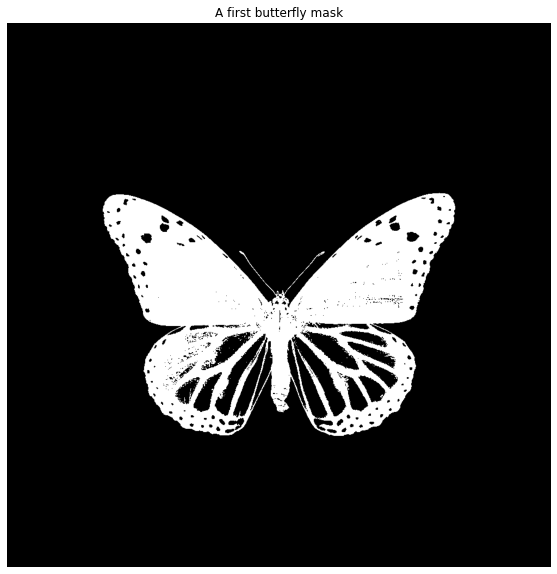

In [76]:
# Display the obtained mask
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(mask1_arr, cmap='gray')
ax.axis('off')
plt.title('A first butterfly mask')
plt.show()

That's quite good! However, there are "holes" in the mask of the butterfly. For further process, we need to fill these holes.
One common solution is to take all the regions in the complementary image, namely the binary image where the 1 and 0 intensity values are inverted.
Holes correspond then to regions not touching the border of the image.

In [77]:
# Compute the connected components (i.e regions) of the complementary image
ccs_arr, nb_ccs = ndi.label(1 - mask1_arr)

# List of ccs indexes 
cc_ids = list(range(1, nb_ccs + 1))

# Compute the array of the border of the image 
border_arr = np.zeros((sx1, sy1)).astype(int)
border_arr[0, :] = 1
border_arr[sx1-1, :] = 1
border_arr[:, 0] = 1
border_arr[:, sy1-1] = 1

# Get the indexes of the regions touching the border
border_cc_ids = np.unique(ccs_arr[border_arr == 1])
border_cc_ids = list(border_cc_ids[border_cc_ids > 0])

#Remove the corresponding indexes
cc_ids = list(set(cc_ids) - set(border_cc_ids))

#Fill each detected holes    
for cc_id in cc_ids:
    mask1_arr[ccs_arr == cc_id] = 1        

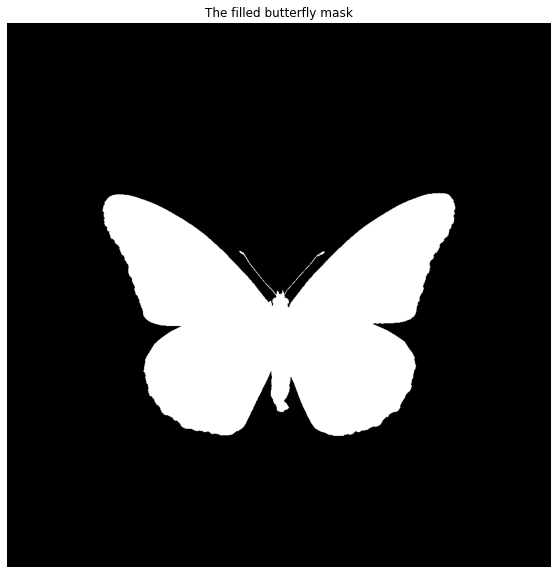

In [78]:
#Display the filled mask
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(mask1_arr, cmap='gray')
ax.axis('off')
plt.title('The filled butterfly mask')
plt.show()

In practice, we will use functions already implemented for binary hole filling, for example the Scipy's "binary_fill_holes".

In [79]:
# Equivalent function for binary hole filling
mask1_arr = ndi.binary_fill_holes(mask1_arr).astype(int)

## b) The bounding box of the butterlfy

Now we know some basics to process images, we are ready to search the line of symmetry of our butterfly! Before starting the optimization process, need first to find a rather good initialization. When looking at the butterfly image, the vertical line cutting the butterfly in half seems a good choice! We can take the middle vertical line of the rectangle that best fits the binary object. We will now automatically detect this best fitting rectangle, called the bounding box.

In [80]:
# Coordinates of the pixels belonging to the mask
[x1, y1] = np.where(mask1_arr == 1)
print('The butterfly mask is composed of {0} pixels'.format(len(x1)))

The butterfly mask is composed of 171548 pixels


In [81]:
# Bounding box of the butterfly mask
bb1_arr = np.zeros((sx1, sy1)).astype(int)
bb1_arr[np.min(x1):np.max(x1)+1, np.min(y1):np.max(y1)+1] = 1

<font color='blue'> Question 1: Compute and display the percentage of butterfly pixels included in the bounding box </font>

In [82]:
[x1bb, y1bb] = np.where(bb1_arr == 1)
percentage = ((np.sum(mask1_arr[bb1_arr == 1]))/len(x1))* 100
#if(percentage > 100 ) : percentage = 100
print('The percentage of butterfly pixels included in the bounding box is {0} %'.format(percentage))

The percentage of butterfly pixels included in the bounding box is 100.0 %


<font color='blue'> Question 2: Compute and display the percentage of the bounding box that is occupied by the butterfly mask </font>

In [83]:
print('The percentage of the bounding box that is occupied by the butterfly mask is {0} %'.format((len(x1)/len(x1bb)) * 100))

The percentage of the bounding box that is occupied by the butterfly mask is 59.22473554837462 %


Now we have the bounding box, we can simply compute the vertical and horizontal lines cutting it in half, and then check our results visually.

In [84]:
# Coordinates of the center of the bounding box
x1_bb_center = int(np.round(0.5 * (np.max(x1) - np.min(x1)) + np.min(x1)))
y1_bb_center = int(np.round(0.5 * (np.max(y1) - np.min(y1)) + np.min(y1)))

# Vertical and horizontal lines going through the center of the bb
line1_arr = np.zeros((sx1, sy1)).astype(int)
line1_arr[:, y1_bb_center] = 1

line2_arr = np.zeros((sx1, sy1)).astype(int)
line2_arr[x1_bb_center, :] = 1

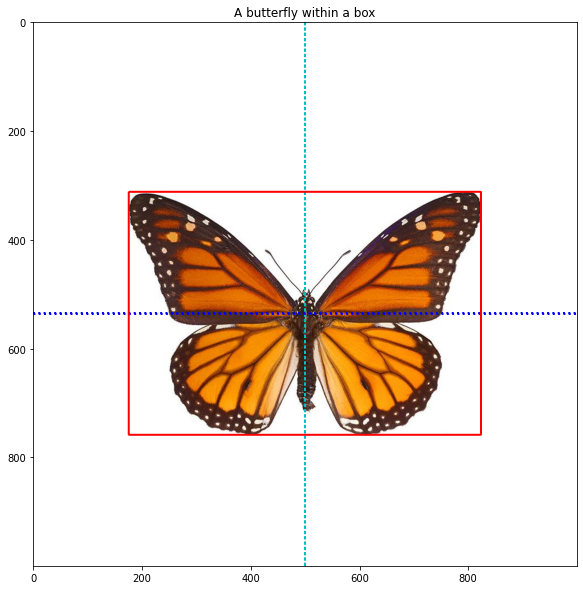

In [85]:
#Display the transformed image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(im1_arr)
ax.contour(line1_arr, [0.5], colors = 'c', linewidths = [2, 2], linestyles = 'dotted')
ax.contour(line2_arr, [0.5], colors = 'b', linewidths = [2, 2], linestyles = 'dotted')
ax.contour(bb1_arr, [0.5], colors = 'r', linewidths = [2, 2])
plt.title('A butterfly within a box')
plt.show()

Finally, to save some computation time, we crop the image to its bounding box.

In [86]:
#Restrict the input images to the butterfly bounding box
im1_arr = im1_arr[np.min(x1):np.max(x1)+1, np.min(y1):np.max(y1)+1]
mask1_arr = mask1_arr[np.min(x1):np.max(x1)+1, np.min(y1):np.max(y1)+1]
glim1_arr = glim1_arr[np.min(x1):np.max(x1)+1, np.min(y1):np.max(y1)+1]
sx1, sy1 = mask1_arr.shape
print('Cropped image of dimension {0} x {1} pixels'.format(sx1, sy1))

# Coordinates of the center of the image
x1_bb_center = int(np.round(sx1 / 2))
y1_bb_center = int(np.round(sy1 / 2))

# Vertical and horizontal lines going through the center of the cropped image
line1_arr = np.zeros((sx1, sy1)).astype(int)
line1_arr[:, y1_bb_center] = 1

line2_arr = np.zeros((sx1, sy1)).astype(int)
line2_arr[x1_bb_center, :] = 1

Cropped image of dimension 447 x 648 pixels


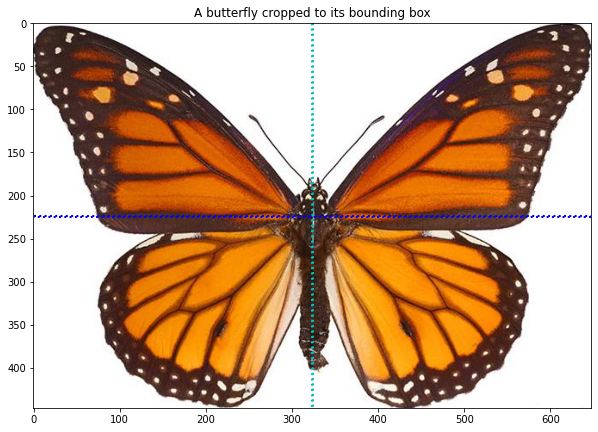

In [87]:
#Display the transformed image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(im1_arr)
ax.contour(line1_arr, [0.5], colors = 'c', linewidths = [2, 2], linestyles = 'dotted')
ax.contour(line2_arr, [0.5], colors = 'b', linewidths = [2, 2], linestyles = 'dotted')
plt.title('A butterfly cropped to its bounding box')
plt.show()

## c) Symmetry analysis

We are now ready to start our bilateral symmetry detection! We first need to define the function computing the symmetric image with respect to any line. We need to compute for each pixel (i.e point) its symmetric with respect to the line. Note that these coordinates values will be different considering a vertical, horizontal, or any different line of symmetry!

<font color='blue'> Question 3: Complete the function below to compute the coordinates  of the symmetric point of each pixel </font>

<font color='red'>
Warning: the image system, as loaded by Python, is not the strict Cartesian system... the axes are inverted! After modifying the code in the function "symmetry_image_v0", the display of the visual results helps you verifying the accuracy of your modifications!
</font>

In [88]:
def symmetry_image_v0(p, arr, background_val):
    """ Symmetric image with respect to a line of equation ax + by + c = 0

    Parameters
    ----------
    p: vector of floats
        vector containing the line of symmetry with parameters a, b, c
    arr: 2D array
        the input (binary or grey level) image 
    plane
    background_val : float/int
        the background intensity value

    Returns
    -------
    sym_arr: 2D array
        the output symmetric image
    """

    # Get back the line parameters
    a, b, c = p

    # Image size and type
    s1, s2 = arr.shape
    arr_type = type(arr[0, 0])

    # Coordinates of the region of interest
    [x, y] = np.where(arr > 0)

    # Coordinates (xr, yr) of the symmetric point of (x, y) with respect to
    #  a vertical line in the image system
    if a == 0 and b != 0:
        yr = -y - 2*c/b
        xr = x

    # Coordinates (xr, yr) of the symmetric point of (x, y) with respect to
    # an horizontal line in the image system
    elif a != 0 and b == 0:
        xr = -2*c/a - x
        yr = y

    # Coordinates (xr, yr) of the symmetric point of (x, y) with respect to
    # any different line
    else:
        xr = x - (2*a * (a*x + b*y + c)) / (a**2 + b**2)
        yr = y - (2*b * (a*x + b*y + c)) / (a**2 + b**2)

    # cast to integer and only keep coordinates within the image !
    xr = (np.round(xr)).astype(int)
    yr = (np.round(yr)).astype(int)

    x = x[xr < s1]
    y = y[xr < s1]
    yr = yr[xr < s1]
    xr = xr[xr < s1]

    x = x[yr < s2]
    y = y[yr < s2]
    xr = xr[yr < s2]
    yr = yr[yr < s2]

    x = x[xr >= 0]
    y = y[xr >= 0]
    yr = yr[xr >= 0]
    xr = xr[xr >= 0]

    x = x[yr >= 0]
    y = y[yr >= 0]
    xr = xr[yr >= 0]
    yr = yr[yr >= 0]

    # Take into account the background value
    if background_val == 0:
        sym_arr = np.zeros((s1, s2), dtype=arr_type)
    else:
        sym_arr = background_val * np.ones((s1, s2), dtype=arr_type)

    # Compute the symmetric array
    for i in range(len(xr)):
        sym_arr[xr[i], yr[i]] = arr[x[i], y[i]]

    return sym_arr


We can now vizualize the resulted symmetric image on the binary mask of the butterfly.

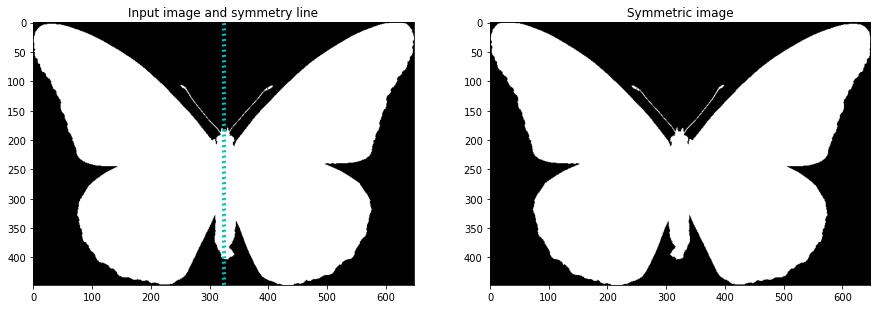

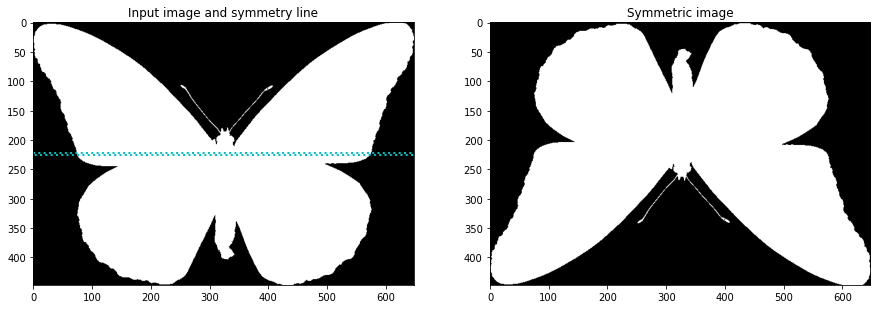

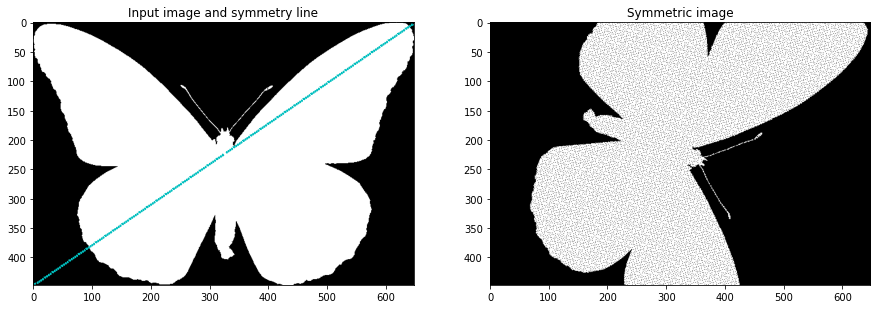

In [89]:
# Symmetric images with respect to a horizontal, vertical, or any different line
input_arr = np.copy(mask1_arr)
back_val = np.min(input_arr)
s1, s2 = input_arr.shape
y_arr, x_arr = np.meshgrid(range(s2), range(s1)) 

init_ps = [[0, 1, -y1_bb_center], 
           [1, 0, -x1_bb_center],
           [(sy1 - 1) / (sx1 - 1), 1 , -sy1 - 1.5]]

for init_p in init_ps:
    #Symmetric image with given parameters
    sym_arr = symmetry_image_v0(init_p, input_arr, back_val)
    #Symmetric line array
    a, b, c = init_p
    line_arr = (np.abs(a * x_arr + b * y_arr + c) <= 1).astype(int)

    #Dislay the result
    fig, ax = plt.subplots(1, 2, figsize=(15, 15))
    ax[0].imshow(input_arr, cmap='gray')
    ax[0].contour(line_arr, [0.5], colors = 'c', linewidths = [2, 2], linestyles = 'dotted')
    ax[0].set_title('Input image and symmetry line')
    ax[1].imshow(sym_arr, cmap='gray')
    ax[1].set_title('Symmetric image')

We see that there are holes in the last symmetric image: there are pixels missing!

Indeed, we assigned to each pixel (x,y) its symmetric point (xr, yr), hoping that this point would not be out of the image.
To solve this problem of missing values, we have to consider the inverse process: check for each pixel of the symmetric image if we can find the associated pixel on the input image.

<font color='blue'> Question 4: Complete the function below to compute the symmetric point of each pixel in a proper way </font>

In [90]:
def symmetry_image(p, arr, background_val):
    
    """ Symmetry image by a line of equation ax + by + c = 0
        
    Parameters
    ----------
    p: vector
        vector containing the symmetry line parameters a, b, c
    arr: 2D array
        the input (binary or grey level) image (non negative intensities)
    plane
    background_val : float/int
        the background intensity value
        
    Returns
    -------
    sym_arr: 2D array
        the output symmetry image
    """
    
    a, b, c = p

    # Image size
    s1, s2 = arr.shape
    arr_type = type(arr[0, 0])
    
    # Coordinates of the whole image
    y_arr, x_arr = np.meshgrid(range(s2), range(s1))
    xr = x_arr.flatten()
    yr = y_arr.flatten()

    # Coordinates (x, y) of the input point as a function of its symmetric 
    # point (xr, yr) with respect to a vertical line in the image system 
    if a == 0 and b != 0:     
        y = -yr - 2*c/b
        x = xr

    # Coordinates (x, y) of the input point as a function of its symmetric 
    # point (xr, yr) with respect to an horizontal line in the image system    
    elif a != 0 and b == 0:       
        x = -2*c/a - xr
        y = yr
      
    else:
    # Coordinates (x, y) of the input point as a function of its symmetric 
    # point (xr, yr) with respect to any different line
        x = xr - (2*a * (a*xr + b*yr + c)) / (a**2 + b**2)
        y = yr - (2*b * (a*xr + b*yr + c)) / (a**2 + b**2)
        
    #cast to integer and only keep coordinates within the image ! 
    x = (np.round(x)).astype(int)
    y = (np.round(y)).astype(int)

    xr = xr[x < s1]
    yr = yr[x< s1]
    y = y[x < s1]
    x = x[x < s1]
    
    xr = xr[y < s2]
    yr = yr[y < s2]    
    x= x[y < s2]
    y= y[y < s2]
    
    xr = xr[x >= 0]
    yr = yr[x >= 0]  
    y = y[x >= 0]
    x = x[x >= 0]

    xr = xr[y >= 0]
    yr = yr[y >= 0] 
    x = x[y >= 0]
    y = y[y >= 0]

    # Consider the background
    if background_val == 0:
        sym_arr = np.zeros((s1, s2), dtype=arr_type)
    else:
        sym_arr = background_val * np.ones((s1, s2), dtype=arr_type)
    
    # Create the symmetry array
    for i in range(len(xr)):
        sym_arr[xr[i], yr[i]] = arr[x[i], y[i]]
        
    return sym_arr

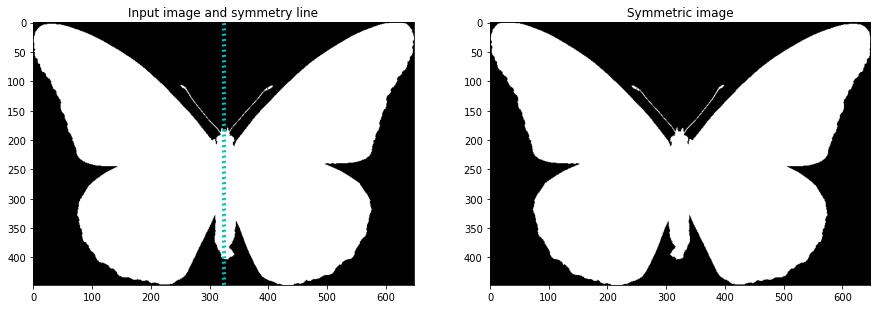

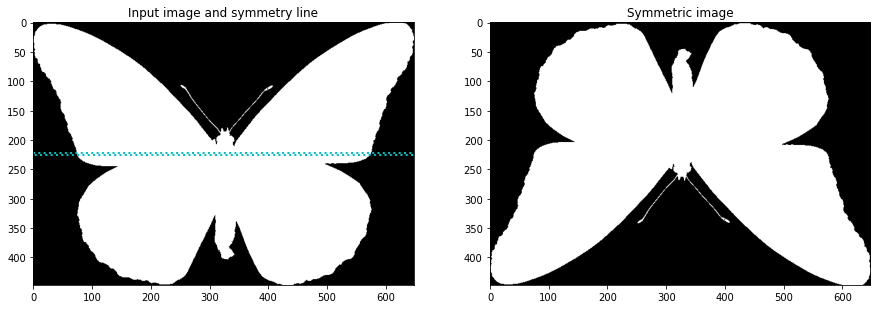

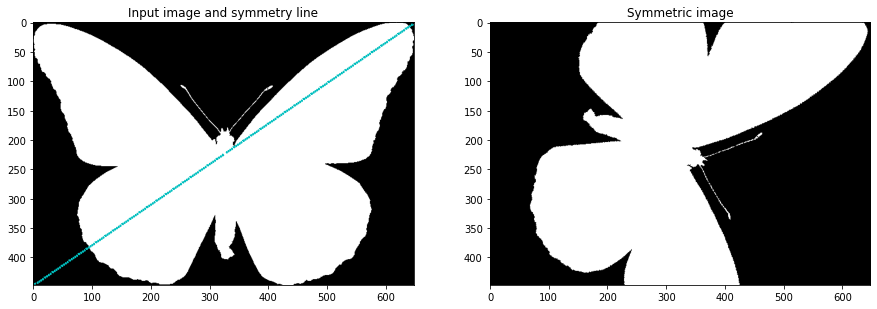

In [91]:
#Check your improved algorithm
for init_p in init_ps:
    #Symmetric image with given parameters
    sym_arr = symmetry_image(init_p, input_arr, back_val)

    #Symmetric line array
    a, b, c = init_p
    line_arr = (np.abs(a * x_arr + b * y_arr + c) <= 1).astype(int)

    #Dislay the result
    fig, ax = plt.subplots(1, 2, figsize=(15, 15))
    ax[0].imshow(input_arr, cmap='gray')
    ax[0].contour(line_arr, [0.5], colors = 'c', linewidths = [2, 2], linestyles = 'dotted')
    ax[0].set_title('Input image and symmetry line')
    ax[1].imshow(sym_arr, cmap='gray')
    ax[1].set_title('Symmetric image')

Our function to compute the symmetric image of any binary or grey level image should now be working perfectly!
We need now to define the loss L to minimize. Considering that the input and its symmetric image are very similar, we define the following loss:


L =  $\displaystyle \frac{1}{n} \sum_{x \in M} (I(x) - I_{sym}(x)) ^ 2$

with $I(x)$ the intensity value of the image $I$ at the pixel x, supposing $x=(x_1, x_2)$, $I_{sym}$ the intensity value of the symmetric image $I_{sym}$ at the same pixel, and $M$ a binary mask composed of $n$ pixels

<font color='blue'> Question 5: Complete the loss function below </font>

In [92]:
#Initialize the vector of loss values
global losses

# Define the loss function
def sym_loss(p, arr, mask_arr, background_val):   
    
    """
    Parameters
    ----------
    p: 3-uplet
        vector containing the symmetry line parameters a, b, c
    arr: 2D array
        the input (binary or grey level) image 
    plane
    mask_arr: 2D array
        the input binary mask
    plane
    background_val : float/int
        the background intensity value
        
    Returns
    -------
    loss: float
        the loss value
    """

    # Image size
    s1, s2 = arr.shape   

    # Symmetric image with respect to the input line
    sym_arr = symmetry_image(p, arr, background_val)

    # Compute the current loss value
    loss = np.mean((sym_arr[mask_arr==1]-arr[mask_arr==1])**2)
    
    #Update the vector of loss values
    losses.append(loss)

    return loss

We can now choose automatically the parameters of the initial symmetry line ! 

<font color='blue'> Question 6: 
- Complete the code below to automatically select the best initialization between the horizontal and vertical lines cutting the butterfly bounding box in half, and considering the butterfly mask as the input image. 
- Display the best initial loss value and the associated parameters. </font> 

In [93]:
# Initialize the list containing the loss evolution
losses = []

for init_p in init_ps:
  
    loss = sym_loss(init_p, input_arr, mask1_arr, back_val)

print(losses)

min_loss = min(losses)
print("the best initial loss value is", min_loss)

min_loss_position = losses.index(min_loss)
best_parameters = init_ps[min_loss_position]
print("The best symetry line you choose has the following parameters :", best_parameters)


[0.016286986732576305, 0.3516625084524448, 0.4715764683936857]


TypeError: 'numpy.float64' object is not callable

We have anything we need to start the optimization process!
We first try the Nelder–Mead method, also called the downhill simplex method.

<font color='blue'> Question 6: What is the geometric form of the created simplex at each iteration?</font> 

<font color='blue'>
...To complete...</font> 

<font color='blue'>
Question 7: Apply the Nelder-Mead method on the binary mask of the butterfly, taking the best previous initialization as the initial symmetry plane. You have to use the function "minimize" of SciPy optimize, with the appropriate method. Ensure that you get also the best parameter setting at each iteration ('return_all' argument).
</font> 

In [ ]:
# Initialize the list containing the loss evolution
losses = []

options = {
    "return_all" : True
}
optimize.minimize(sym_loss,parameters
,method='Nelder-Mead')

<font color='blue'>
Question 8: Display the optimization result (the  OptimizeResult object).
</font> 

In [ ]:
#...To complete...

<font color='blue'>
Question 9: Display the evolution of the "losses" vector. 
    
- What does it represent, and what is the associated output attribute (you may also check the documentation)? 
- Is it converging to a minimal value ?  
</font>   

In [ ]:
#...To complete...

<font color='blue'>
...To complete...</font> 

<font color='blue'>
Question 10: Display the evolution of the loss accross the iterations, using the vector of best parameters obtained at each iteration.
    
- What is the associated output attribute (you may also check the documentation)?
- Is it converging ?  
</font>   

In [ ]:
#...To complete...

<font color='blue'>
...To complete...</font> 

<font color='blue'>
Question 11: Display the final symmetric image and the associated loss. 
    
- Is the final symmetry image similar to the initial one? 
- What do you conclude on the butterfly symmetry regarding shape ?
</font>   

In [ ]:
#...To complete...

<font color='blue'>
...To complete...</font> 

We will now analyse the influence of the initialization.

<font color='blue'>
Question 12: Apply the Nelder-Mead method on the binary butterfly image, taking as an initial line of symmetry one of the diagonal lines cutting the input image in half.
    
- Display and analyze the evolution of the function evaluation, the loss evolution, the final line of symmetry and final loss value.
    
- Conclude on the influence of the initialization on the performances.  
</font>   

In [ ]:
# Initialize the list containing the loss evolution
losses = []

#...To complete...

<font color='blue'>
...To complete...</font> 

We will now analyse the influence of the algorithm.

<font color='blue'>
Question 13: Apply the Powell method on the binary butterfly image, taking the best previous initialization as the initial line of symmetry.

- Display and analyze the evolution of the function evaluation, the loss evolution, the final line of symmetry and final loss value.
- Do you favor a specific algorithm for this application?  
</font>  

In [ ]:
# Initialize the list containing the loss at each iteration
losses = []

#...To complete...

<font color='blue'>
...To complete...</font> 

Finally, we will analyse the influence of the input image.

<font color='blue'>
Question 14: Complete the code below to automatically select the best initialization between the horizontal and vertical lines cutting the butterfly bounding box in half, and considering the butterfly grey level image as the input image. 
    
- Display the best initial loss value and the associated parameters.
- Apply your favorite algorithm on the grey level butterfly image, taking the best previous initialization as the initial symmetry plane.
- Display and analyze the evolution of the function evaluation, the loss evolution, the final symmetry line and final loss value.
- What do you conclude on the bilateral symmetry of the butterfly regarding patterns or colors ?
</font> 

In [ ]:
# Initialize the list containing the loss at each iteration
losses = []

#...To complete...

<font color='blue'>
...To complete...</font> 